### Exploratory Spatial Data Analysis

inspired by the great course 'SPATIAL DATA SCIENCE WITH PYDATA' by Levi John Wolf & Sergio Rey given at GeoPython 2018 http://2018.geopython.net/#close

In [193]:
%matplotlib inline
import sys
import os
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
import numpy as np
import geopandas as gp
from shapely import wkt, wkb
from shapely.geometry import Point, Polygon, MultiPolygon, LineString, MultiLineString
import contextily as ctx
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")

# helper functions
sys.path.insert(0, 'helper_functions/')

# paths + files
PATH_TO_DATA = '/home/diederik/ams/pyprojects/geospatial_analysis/data/'
AIR_BNB_FILE_MUNGED = 'airbnb_munged.csv' # munged version 
STADSDELEN = 'sd.csv'
BUURT_COMBINATIES = 'buurt_combi.csv'
BUURT = 'buurt.csv'

In [3]:
# load airbnb data from csv
crs_initial = {'init': 'epsg:28992'}
converters = {'geometry': lambda x: wkt.loads(x), 'sd_id': str, 'b_id': str}
# airbnb
df= (pd.read_csv(PATH_TO_DATA + AIR_BNB_FILE_MUNGED, converters=converters, 
                 parse_dates=['last_review']))
df = gp.GeoDataFrame(df, crs=crs_initial, geometry='geometry')
# stadsdelen
sd = pd.read_csv(PATH_TO_DATA + STADSDELEN, converters=converters)
sd = gp.GeoDataFrame(sd, crs=crs_initial, geometry='geometry')
# buurtcombinaties
# bc = pd.read_csv(PATH_TO_DATA + BUURT_COMBINATIES, converters=converters)
# bc = gp.GeoDataFrame(bc, crs=crs_initial, geometry='geometry')
# buurten
buurt = pd.read_csv(PATH_TO_DATA + BUURT, converters=converters)
buurt = gp.GeoDataFrame(buurt, crs=crs_initial, geometry='geometry')

In [195]:
df.head(1)

,id,name,host_id,host_name,neighbourhood,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,geometry,sd_code,sd_name,bc_id,bc_name,b_id,b_name
0,2818,Quiet Garden View Room & Super Fast WiFi,3159,Daniel,Oostelijk Havengebied - Indische Buurt,Private room,69.0,3,233,2018-06-24,2.06,1,116,POINT (124637.2554813915 486523.2381693435),M,Oost,3630012052077,Indische Buurt Oost,03630000000577,Noordoostkwadrant Indische buurt


In [ ]:
df.geometry.x

In [196]:
df['lat'] = df.geometry.x

0        124637.255481
1        124783.399754
2        124573.248329
3        124571.123777
4        124552.066029
5        124630.361028
6        124923.920923
7        124651.529418
8        124714.303752
9        124632.249941
10       124763.194209
11       124693.882195
12       124557.394191
13       124857.228772
14       124952.207846
15       124796.612506
16       124767.326400
17       124851.504197
18       124770.197626
19       124604.523143
20       124813.627834
21       124681.971892
22       124768.634464
23       124801.295595
24       124763.142860
25       124614.091668
26       124610.708838
27       124572.680883
28       124637.781430
29       124797.534242
             ...      
19286    128076.295964
19287    128249.739145
19288    128047.223168
19289    127556.059414
19290    127995.932316
19291    128039.847158
19292    128152.663678
19293    128089.528720
19294    128343.533661
19295    128441.054169
19296    128599.477844
19297    128403.550895
19298    12

In [ ]:
sns.kdeplot(df['longitude'], df['latitude'], shade=True, cmap='viridis');

### 1) Where are the most expensive apartments located

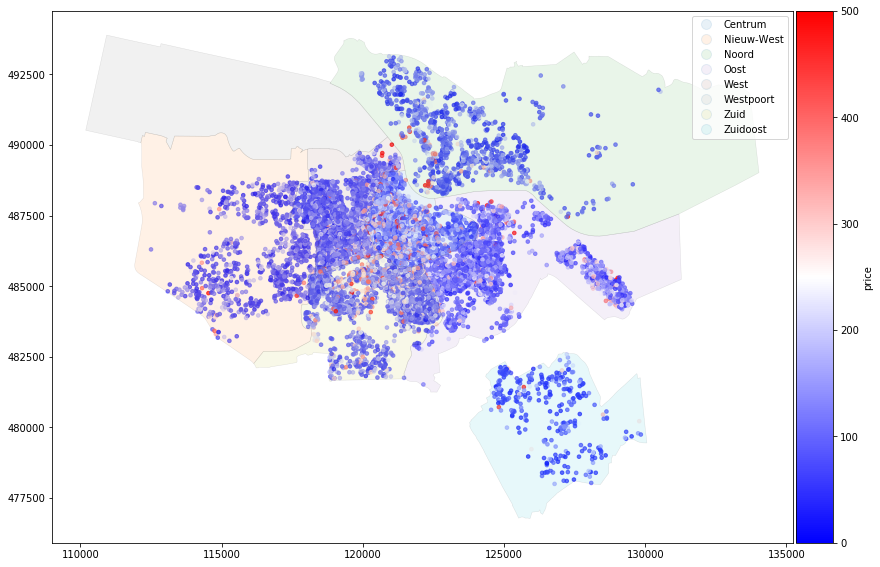

In [8]:
# hell of a job to get the adjusted colorbar size (Argghh)
style_kwds = {'markersize': 13,'alpha': .7}
vmin, vmax = 0, 500

fig, ax= plt.subplots(figsize=[14,14])
ax = df.plot(column='price', ax=ax, cmap='bwr', **style_kwds)

sm = plt.cm.ScalarMappable(cmap='bwr', norm=plt.Normalize(vmin=vmin, vmax=vmax))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
# fake up the array of the scalar mappable. 
sm._A = []
plt.colorbar(sm, cax, label='price')
# adjust colorbar tick formatting
cb = ax.get_figure().get_axes()[1]
#cb.set_ticks(['€{0:.0f}'.format(ytick) for ytick in yticks]);

style_kwd_sd = {'alpha': .1, 'linewidth': .5, 'edgecolor': 'k'}
sd.plot(ax=ax, **style_kwd_sd, column='sd_name', legend=True)

hmm not the best map. Let's grab a basemap using contextily, a package to provide basemaps for data, best used for data in webmercator (epsg:3857 or 4326) or raw WGS lon-lat coordinates.

Here we grab the basemap images for the total_bounds of our study area at a given zoom level, also specifying a different tile server from the default: the Stamen Maps toner-lite tiles for its aesthetics.

In [50]:
# convert to webmercator
df2 = df.to_crs(epsg=3857)
buurt = buurt.to_crs(epsg=3857)

In [51]:
basemap, bounds = ctx.bounds2img(*df2.total_bounds, zoom=10, 
                                 url='http://tile.stamen.com/toner-lite/tileZ/tileX/tileY.png')

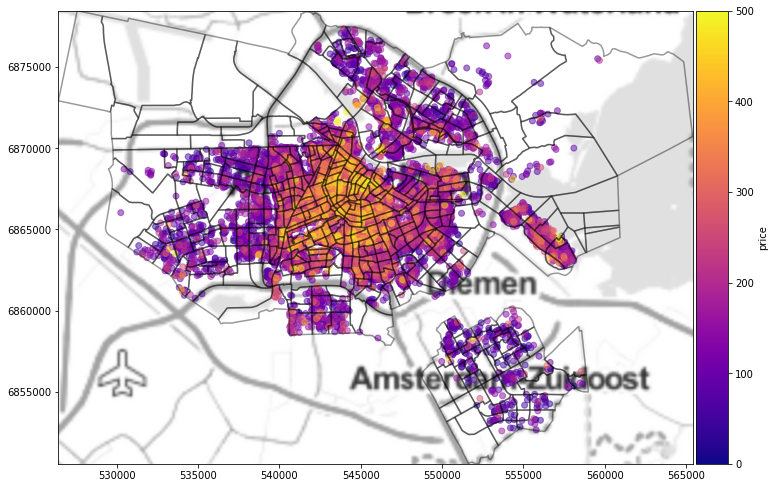

In [117]:
f = plt.figure(figsize=(12,12))
ax = plt.gca()
buurt.boundary.plot(color='k', ax=ax, alpha=.4)
ax.imshow(basemap, extent=bounds, interpolation='gaussian', alpha= .8)
ax.axis(buurt.total_bounds[np.asarray([0,2,1,3])])
df2.sort_values('price').plot('price', ax=ax, marker='o', cmap='plasma', alpha=.5)

sm = plt.cm.ScalarMappable(cmap='plasma', norm=plt.Normalize(vmin=vmin, vmax=vmax))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
# fake up the array of the scalar mappable. 
sm._A = []
plt.colorbar(sm, cax, label='price')

### adjecency graphs represent how neighbourdhood polygons relate to each other

The **queen contiguity weight** is commonly-used reflecting adjacency relationships as a binary indicator variable denoting whether or not a polygon shares an edge/ vertex with another polygon. See how this works focusing on the neighborhoods in Stadsdeel 'West'

Queen contiguigy requires either an edge or a vertex and **Rook contiguity** requires only shared edges. (considers observations as neighboring only when they share an **edge**)

In [156]:
# buurt = buurt.to_crs(epsg=28992)
# sd= sd.to_crs(epsg=28992)

In [4]:
# join the Stadsdelen to buurten
buurt_enriched = gp.sjoin(buurt, sd, how='inner', op = 'intersects')
buurt_west = buurt_enriched[buurt_enriched.sd_name == 'West'].reset_index()

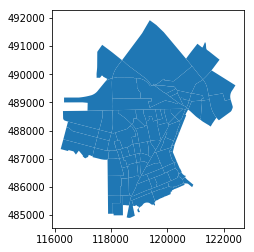

In [5]:
buurt_west.plot()

In [5]:
import libpysal.api as lp
Qneighbs_west = lp.Queen.from_dataframe(buurt_west) # construct Queen adjacency graph
Rneighbs_west = lp.Rook.from_dataframe(buurt_west) # construct Rook adjacency graph

In [6]:
obs_ = 5
print ('Queen contiguity {}th observation neighbors {} and their weights {}'.\
       format(obs_, Qneighbs_west[obs_].keys(), Qneighbs_west[obs_].values())) 
print ('Rook contiguity {}th observation neighbors {} and their weights {}'.\
       format(obs_, Rneighbs_west[obs_].keys(), Rneighbs_west[obs_].values())) 

Queen contiguity 5th observation neighbors dict_keys([48, 4, 6, 47]) and their weights dict_values([1.0, 1.0, 1.0, 1.0])
Rook contiguity 5th observation neighbors dict_keys([4, 6, 47]) and their weights dict_values([1.0, 1.0, 1.0])


The weights dictionary and the `buurt` dataframe use the same index. By combining the weight dictionary's index and its neighbors' indices together in one list called `focal_neighbors` , we can view the observation (3rd) and its neighbors in the dataframe by putting. 

[5, 4, 6, 47]


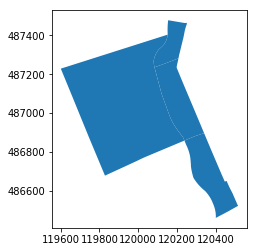

In [7]:
focal_neighbors = [obs_]
focal_neighbors.extend(Rneighbs_west.neighbors[obs_]) # extend focal with its neighbours
print(focal_neighbors)
# plot the neighbours
buurt_west.loc[focal_neighbors].plot();

In [12]:
# the neighourhoods adjacent to the focal area 
buurt_west.loc[focal_neighbors, :]

,index,geometry,b_id,b_name,index_right,sd_code,sd_id,sd_name
5,74,"POLYGON ((120084.0516624 487235.7249929, 12010...",03630000000506,Groenmarktkadebuurt,4,E,03630011872036,West
4,72,"POLYGON ((120250.7444797 487465.1179719, 12025...",03630000000503,Marnixbuurt Midden,4,E,03630011872036,West
6,75,"POLYGON ((120400.1801656 486458.6363454, 12040...",03630000000507,Marnixbuurt Zuid,4,E,03630011872036,West
47,191,"POLYGON ((119828.4968949 486676.896265, 119746...",03630000000862,Da Costabuurt Noord,4,E,03630011872036,West


A full, dense matrix with all pairwise relationships is created with `.full` method, or when `pysal.full` is called on a weights object:

In [8]:
Wmatrix, ids = Qneighbs_west.full()
Wmatrix

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.]])

,focal,neighbor,weight
0,0,2,1.0
1,0,3,1.0
2,0,38,1.0
3,0,39,1.0
4,0,10,1.0


In [28]:
print ('{0:.2f}% of all the possible connections N^2 links between any two observations \
actually make it into the adjacency graph'.format(Qneighbs_west.pct_nonzero))

5.98% of all the possible connections N^2 links between any two observations actually make it into the adjacency graph


In [29]:
import scipy.sparse.csgraph as csgraph


In [9]:
n_neighbors = Wmatrix.sum(axis=1) # how many neighbors each region has

In [10]:
n_neighbors

array([ 5.,  3.,  5.,  4.,  4.,  4.,  5.,  4.,  7.,  4.,  6.,  4.,  4.,
        3.,  5.,  4.,  5.,  5.,  5.,  4.,  8.,  7.,  5.,  5.,  7.,  5.,
        9.,  6.,  8.,  9.,  6.,  4.,  7.,  8.,  9.,  6.,  7.,  5., 12.,
        7.,  5.,  4.,  6.,  6.,  6.,  8.,  8.,  9.,  7.,  5.,  6.,  6.,
        5.,  6.,  7.,  6.,  7.,  7.,  6.,  8.,  8.,  7.,  7.,  6.,  6.,
        6.,  7.,  6.,  7.,  7.,  5.,  6.,  4.,  6.,  3.,  4.,  4.,  5.,
        5.,  3.,  3.,  3.,  4.,  6.,  5.,  5.,  3.,  3.,  9.,  5.,  6.,
        7.,  7.,  7.,  9.,  8.,  7.,  7.])

### plot the adjacency matrices

- the matplotlib way and using the Queen object plotting method

In [11]:
listarray = []
for c in buurt_west.geometry.centroid:
    listarray.append([c.x, c.y])
centroid_array = np.array(listarray)

print (centroid_array[:3])

[[120662.29552453 488685.7654015 ]
 [120714.26590705 486172.47803208]
 [121027.44138499 488781.54543539]]


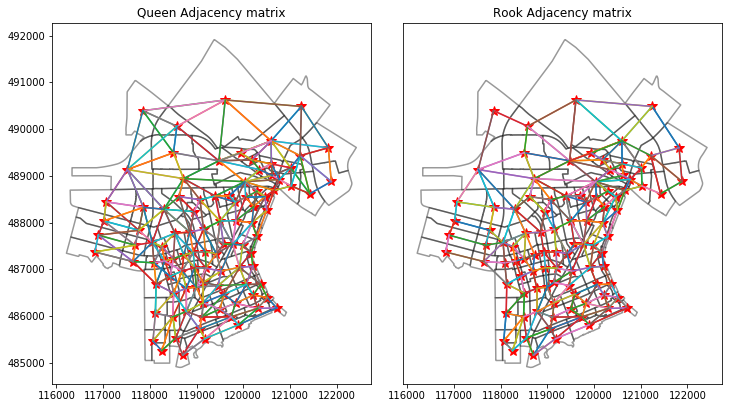

In [12]:
fig, ax = plt.subplots(1, 2, figsize=[12,10])
fig.subplots_adjust(wspace=0.1)
# Queen
ax[0].plot(centroid_array[:, 0], centroid_array[:, 1], '*', ms=10, c='red')
buurt_west.boundary.plot(color='k', ax=ax[0], alpha=.4)
for i, neighs in Qneighbs_west.neighbors.items():
    origin = centroid_array[i]
    for neigh in neighs:
        segment  = centroid_array[[i, neigh]]
        ax[0].plot(segment[:, 0], segment[:, 1], '-')
# Rook
ax[1].plot(centroid_array[:, 0], centroid_array[:, 1], '*', ms=10, c='red')
buurt_west.boundary.plot(color='k', ax=ax[1], alpha=.4)
for i, neighs in Rneighbs_west.neighbors.items():
    origin = centroid_array[i]
    for neigh in neighs:
        segment  = centroid_array[[i, neigh]]
        ax[1].plot(segment[:, 0], segment[:, 1], '-')
ax[0].set(title='Queen Adjacency matrix')
ax[1].set(title='Rook Adjacency matrix', yticks=[]);

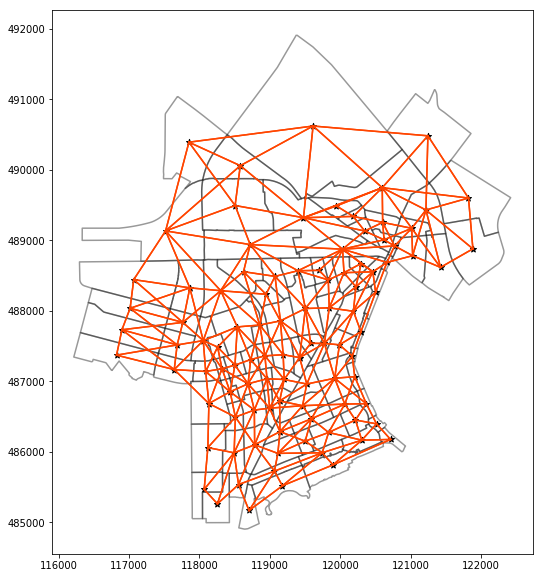

In [45]:
# There are easier to use plotting methods like calling plot on the Queen object
fig, ax = plt.subplots(figsize=[12,10])
buurt_west.boundary.plot(color='k', ax=ax, alpha=.4)
Qneighbs_west.plot(buurt_west, edge_kws=dict(linewidth=1.5, color='orangered'), 
              node_kws=dict(marker='*', s=40), ax=ax);

In [ ]:
# alternative way to see the weights matrix, handy uf you want to work with individual edges:
adjlist = Qneighbs_west.to_adjlist()
adjlist.head(5)

The data used to generate spatial weights can be attached to each of the focal pairs so we can start asking questions about the associated data at that level. F.i median prices per neighbourhood (buurt)

In [44]:
n_price = df.groupby(['b_name']).price.median().to_frame().reset_index()
buurt = pd.merge(buurt, n_price, on = ['b_name'], how='inner')

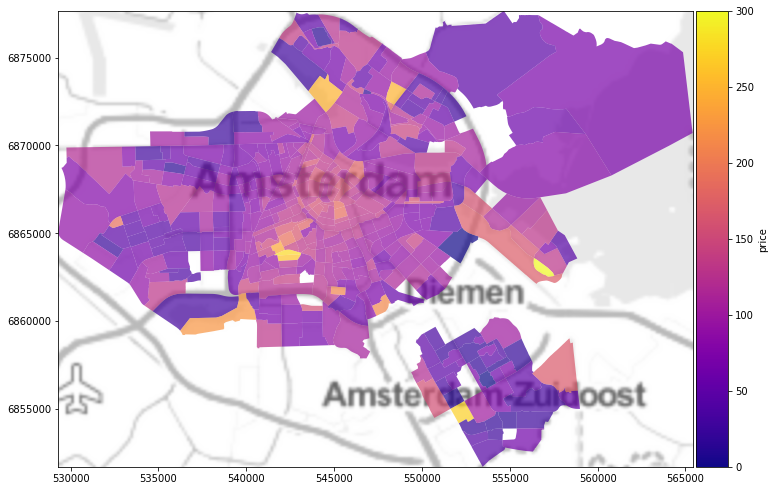

In [60]:
vmin=0
vmax=300
fig, ax = plt.subplots(figsize=(12,12))
# when you only want to plot the boundaries:
buurt.plot('price', cmap='plasma', alpha=.7, ax=ax)
#basemap of the area
ax.imshow(basemap, extent=bounds, interpolation='gaussian', alpha=.6)
ax.axis(buurt.total_bounds[np.asarray([0,2,1,3])])
sm = plt.cm.ScalarMappable(cmap='plasma', norm=plt.Normalize(vmin=vmin, vmax=vmax))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
# fake up the array of the scalar mappable. 
sm._A = []
plt.colorbar(sm, cax, label='price')

hen, to examine the local relationships in price between nearby places, we could merge this information back up with the weights list and get the difference in price between every adjacent neighbourhood.

Usually, these joins involve building links between both the focal and neighbor observation IDs. You can do this simply by piping together two merges: one that focuses on the "focal" index and one that focuses on the "neighbor" index.

Using a suffix in the later merge will give the data joined on the focal index a distinct name from that joined on the neighbor index.

In [63]:
adjlist = adjlist.merge(buurt[['b_name', 'price']], 
                        left_on='focal', right_index=True, how='left')\
                  .merge(buurt[['b_name', 'price']], 
                        left_on='neighbor', right_index=True ,how='left', 
                        suffixes=('_focal', '_neighbor'))

In [77]:
buurt.head(2)

,geometry,b_id,b_name,price
0,"POLYGON ((549941.3002367018 6858072.202228368,...",03630000000485,Hoofdcentrum Zuidoost,140.0
1,"POLYGON ((550127.0052306836 6859314.287428544,...",03630000000492,Venserpolder West,80.0


In [76]:
adjlist.head(2)

,focal,neighbor,weight,b_name_focal,price_focal,b_name_neighbor,price_neighbor,price_difference
0,0,2,1.0,Hoofdcentrum Zuidoost,140.0,D-buurt,60.0,-80.0
1,0,3,1.0,Hoofdcentrum Zuidoost,140.0,E-buurt,62.5,-77.5


In [ ]:
pd.merge(buurt, adjlist)

In [68]:
pricediff = adjlist[['price_focal', 
                     'price_neighbor']].diff(axis=1)
pricediff['price_difference'] = pricediff[['price_neighbor']]
adjlist['price_difference'] = pricediff[['price_difference']]

In [70]:
contrasts = adjlist.groupby(("b_name_focal", 
                 "b_name_neighbor")).price_difference\
                .median().abs().sort_values().to_frame().reset_index()

/home/diederik/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  


In [81]:
contrasts.sort_values(['price_difference',
                       'b_name_focal'],
                       ascending=[False,True]).head(5)

,b_name_focal,b_name_neighbor,price_difference
572,Holendrecht West,Reigersbos Noord,213.0
573,Reigersbos Noord,Holendrecht West,213.0
571,Holendrecht West,Tuindorp Oostzaan West,195.0
570,Tuindorp Oostzaan West,Holendrecht West,195.0
569,Holendrecht West,Tuindorp Oostzaan Oost,180.0


In [86]:
buurt.head(1)

,geometry,b_id,b_name,price
0,"POLYGON ((549941.3002367018 6858072.202228368,...",03630000000485,Hoofdcentrum Zuidoost,140.0


In [87]:
sd.head(1)

,sd_code,geometry,sd_id,sd_name
0,B,"POLYGON ((115438.2551681 489780.5773693, 11543...",03630000000020,Westpoort


In [91]:
buurt = buurt.to_crs(epsg =28992)
sd = sd.to_crs(epsg=28992)
buurt = gp.sjoin(buurt, sd, how='inner', op ='intersects')

In [95]:
buurt = buurt
buurt['price'].fillna((buurt['price'].mean()), inplace=True)

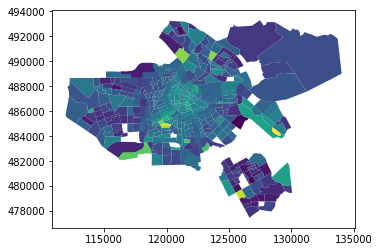

In [97]:
buurt.plot(column='price')

In [98]:
Qneighbs_ams =  lp.Queen.from_dataframe(buurt)
Qneighbs_ams.transform = 'r'

### Attribute Similarity ###

So the spatial weight between neighborhoods $i$ and $j$ indicates if the two 
are neighbors (i.e., geographically similar). What we also need is a measure of
attribute similarity to pair up with this concept of spatial similarity. The
**spatial lag** is a derived variable that accomplishes this for us. For neighborhood
$i$ the spatial lag is defined as: $$y_i = \sum_j w_{i,j} y_j$$

In [99]:
buurt.head(2)

,geometry,b_id,b_name,price,index_right,sd_code,sd_id,sd_name
0,"POLYGON ((124522.8237961527 481358.7708440677,...",03630000000485,Hoofdcentrum Zuidoost,140.0,7,T,03630000000016,Zuidoost
1,"POLYGON ((124641.2260440674 482116.8593634216,...",03630000000492,Venserpolder West,80.0,7,T,03630000000016,Zuidoost


In [137]:
y = buurt['price'] 
ylag = lp.lag_spatial(Qneighbs_ams, y)

In [103]:
import mapclassify.api as mc
ylagq5 = mc.Quantiles(ylag, k=5)

/home/diederik/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


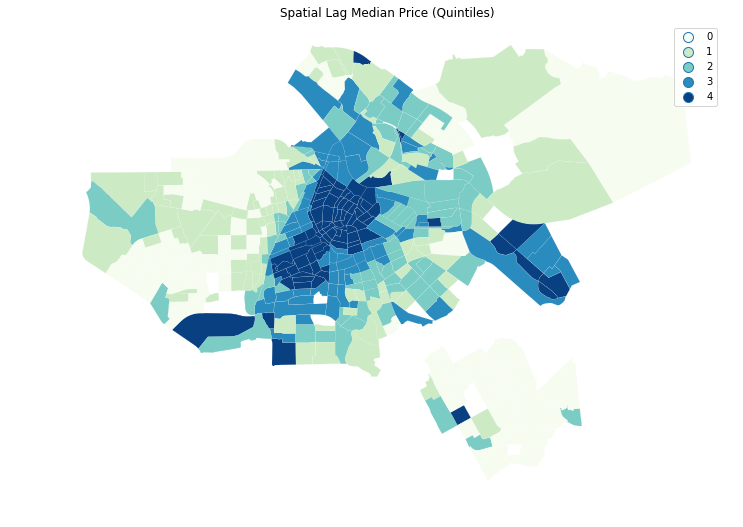

In [106]:
f, ax = plt.subplots(figsize=(12, 12))
buurt.assign(cl=ylagq5.yb).plot(column='cl', categorical=True, \
             k=5, cmap='GnBu', linewidth=0.1, ax=ax, \
             edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Spatial Lag Median Price (Quintiles)");

The quintile map for the spatial lag tends to enhance the impression of value
similarity in space. It is, in effect, a local smoother.

In [109]:
buurt['lag_median_pri'] = ylag
buurt.head(1)

,geometry,b_id,b_name,price,index_right,sd_code,sd_id,sd_name,lag_median_pri
0,"POLYGON ((124522.8237961527 481358.7708440677,...",03630000000485,Hoofdcentrum Zuidoost,140.0,7,T,03630000000016,Zuidoost,110.333333


/home/diederik/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


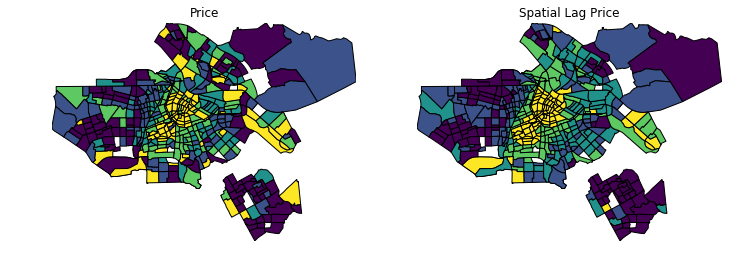

In [113]:
fig ,ax = plt.subplots(1,2,figsize=(12,12))
buurt.plot(column='price', ax=ax[0], edgecolor='k',
           scheme="quantiles",  k=5, cmap='viridis')
ax[0].axis(buurt.total_bounds[np.asarray([0,2,1,3])])
ax[0].set_title("Price")
buurt.plot(column='lag_median_pri', ax=ax[1], edgecolor='k',
           scheme='quantiles', cmap='viridis', k=5)
ax[1].axis(buurt.total_bounds[np.asarray([0,2,1,3])])
ax[1].set_title("Spatial Lag Price")
ax[0].axis('off')
ax[1].axis('off')

In [144]:
yb = y > y.median()
print ('From the toal of {} neighboordhoods in amsterdam, {} have AirBnb list prices above \
the median ({}) and {} below'.format(len(buurt), sum(yb), y.median(), len(buurt) - yb.sum()))

From the toal of 536 neighboordhoods in amsterdam, 257 have AirBnb list prices above the median (120.0) and 279 below


In [147]:
labels = ["0 Low", "1 High"]
[labels[i] for i in yb] 

['1 High',
 '0 Low',
 '0 Low',
 '0 Low',
 '0 Low',
 '0 Low',
 '1 High',
 '0 Low',
 '0 Low',
 '0 Low',
 '0 Low',
 '0 Low',
 '0 Low',
 '0 Low',
 '1 High',
 '0 Low',
 '1 High',
 '0 Low',
 '0 Low',
 '0 Low',
 '0 Low',
 '0 Low',
 '0 Low',
 '0 Low',
 '0 Low',
 '1 High',
 '0 Low',
 '1 High',
 '0 Low',
 '0 Low',
 '0 Low',
 '0 Low',
 '0 Low',
 '0 Low',
 '0 Low',
 '0 Low',
 '0 Low',
 '0 Low',
 '0 Low',
 '0 Low',
 '1 High',
 '1 High',
 '1 High',
 '1 High',
 '0 Low',
 '0 Low',
 '1 High',
 '1 High',
 '1 High',
 '1 High',
 '1 High',
 '1 High',
 '1 High',
 '1 High',
 '1 High',
 '0 Low',
 '1 High',
 '1 High',
 '1 High',
 '1 High',
 '1 High',
 '1 High',
 '1 High',
 '1 High',
 '1 High',
 '1 High',
 '1 High',
 '1 High',
 '1 High',
 '1 High',
 '1 High',
 '1 High',
 '1 High',
 '1 High',
 '1 High',
 '1 High',
 '1 High',
 '1 High',
 '0 Low',
 '0 Low',
 '1 High',
 '1 High',
 '1 High',
 '1 High',
 '1 High',
 '1 High',
 '1 High',
 '1 High',
 '0 Low',
 '1 High',
 '1 High',
 '1 High',
 '1 High',
 '1 High',
 '1 Hi

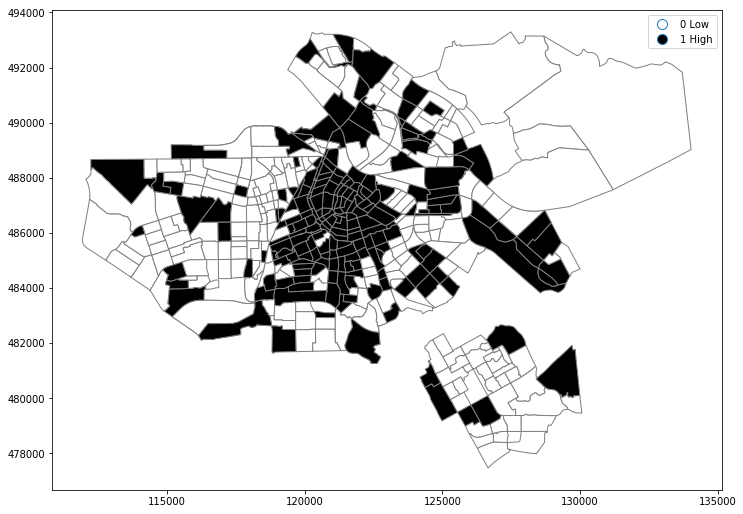

In [148]:
labels = ["0 Low", "1 High"]
yb = [labels[i] for i in 1 * yb] 
buurt['yb'] = yb
fig, ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
buurt.plot(column='yb', cmap='binary', edgecolor='grey', legend=True, ax=ax)

### Join counts ###

One way to formalize a test for spatial autocorrelation in a binary attribute is
to consider the so-called _joins_. A join exists for each neighbor pair of
observations, and the joins are reflected in our binary spatial weights object
`wq`. 

Each unit can take on one of two values "Black" or "White", and so for a given
pair of neighboring locations there are three different types of joins that can
arise:

- Black Black (BB)
- White White (WW)
- Black White (or White Black) (BW)

Given that we have 68 Black polygons on our map, what is the number of Black
Black (BB) joins we could expect if the process were such that the Black
polygons were randomly assigned on the map? This is the logic of join count statistics.

We can use the `esda` package from PySAL to carry out join count analysis:

In [149]:
import esda 
yb = 1 * (y > y.median()) # convert back to binary
Qneighbs_ams.transform = 'b'
np.random.seed(12345)
jc = esda.join_counts.Join_Counts(yb, Qneighbs_ams)

In [150]:
jc.bb + jc.ww + jc.bw

2253.0

In [151]:
buurt.head(2)

,geometry,b_id,b_name,price,index_right,sd_code,sd_id,sd_name,lag_median_pri,yb
0,"POLYGON ((124522.8237961527 481358.7708440677,...",03630000000485,Hoofdcentrum Zuidoost,140.0,7,T,03630000000016,Zuidoost,110.333333,1 High
1,"POLYGON ((124641.2260440674 482116.8593634216,...",03630000000492,Venserpolder West,80.0,7,T,03630000000016,Zuidoost,86.500000,0 Low


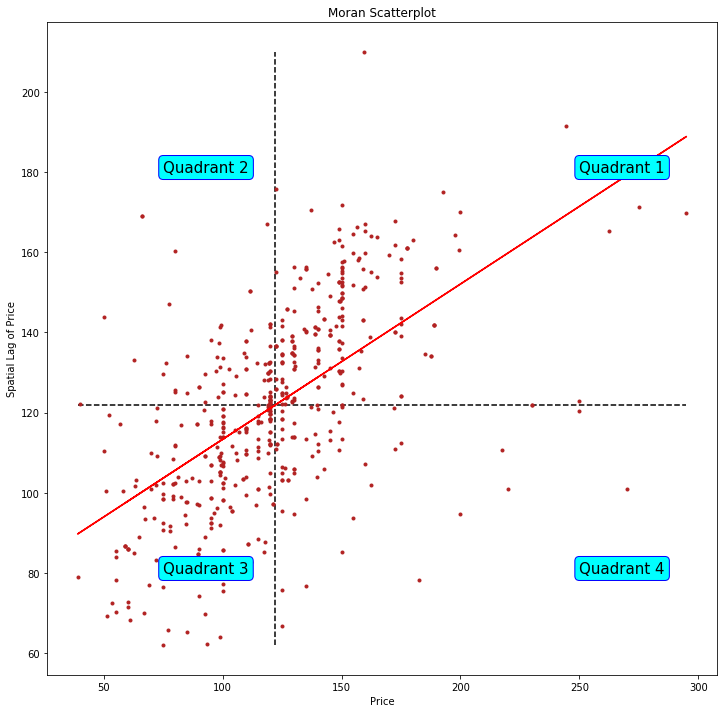

In [189]:
price = buurt['price']
bbox_props = dict(boxstyle="round, pad=0.3", fc="cyan", ec="b", lw=1)
b, a = np.polyfit(price, ylag, 1)
fig, ax = plt.subplots(figsize=(12, 12))

ax.plot(price, ylag, '.', color='firebrick')
ax.annotate('Quadrant 1', xy = (250, 180) , size = 15, bbox=bbox_props)
ax.annotate('Quadrant 2', xy = (75, 180) , size = 15, bbox=bbox_props)
ax.annotate('Quadrant 3', xy = (75, 80) , size = 15, bbox=bbox_props)
ax.annotate('Quadrant 4', xy = (250, 80) , size = 15, bbox=bbox_props)
 # dashed vert at mean of the price
ax.vlines(price.mean(), ylag.min(), ylag.max(), linestyle='--', color='k')
 # dashed horizontal at mean of lagged price 
ax.hlines(ylag.mean(), price.min(), price.max(), linestyle='--', color ='k')

# red line of best fit using global I as slope
ax.plot(price, a + b*price, 'r')
_ = ax.set(title = 'Moran Scatterplot', ylabel = 'Spatial Lag of Price', xlabel = 'Price')

- Quadrant 1 --> High prices in focal neighboorhood, surrounded by nb's with high prices (hotspot)
- Quadrant 2 --> Low prices in focal neighboorhood, surrounded by nb's with high prices (doughnut)
- Quadrant 3 --> Low prices in focal neighboorhood, surrounded by low prices (coldspot)
- Quadrant 4 --> High values in focal neighboorhood, surrounded by nb's with low values (Diamonds)

Now, instead of a single $I$ statistic, we have an *array* of local $I_i$
statistics, stored in the `.Is` attribute, and p-values from the simulation are
in `p_sim`.

In [167]:
li = esda.moran.Moran_Local(y, Qneighbs_ams)
#li.q # locations in the Quadrant

In [190]:
li.q

array([4, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 2, 4, 3, 4, 3, 3, 2, 3, 3,
       3, 3, 3, 4, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1,
       2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4,
       1, 1, 2, 3, 1, 1, 1, 2, 2, 3, 4, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1,
       1, 1, 4, 3, 3, 1, 1, 4, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 3, 4, 3,
       2, 3, 2, 1, 3, 3, 3, 2, 1, 1, 1, 1, 4, 1, 2, 2, 3, 3, 2, 1, 1, 1,
       2, 1, 1, 2, 3, 4, 3, 4, 3, 1, 1, 2, 1, 3, 3, 4, 1, 1, 1, 1, 1, 1,
       2, 1, 1, 2, 2, 3, 3, 1, 1, 3, 3, 3, 1, 4, 4, 4, 3, 4, 1, 3, 3, 3,
       3, 4, 2, 1, 2, 2, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 1, 3, 3, 3, 2,
       1, 2, 3, 3, 1, 4, 3, 3, 1, 2, 1, 1, 3, 3, 2,

In [157]:
(li.p_sim < 0.05).sum()

209

In [158]:
sig = li.p_sim < 0.05 # statistically significant
hotspot = sig * li.q==1
coldspot = sig * li.q==3
doughnut = sig * li.q==2
diamond = sig * li.q==4

In [159]:
spots = ['n.sig.', 'hot spot']
labels = [spots[i] for i in hotspot*1]

### we are plotting signficant non-random spatial association and of type high value next to a high value.

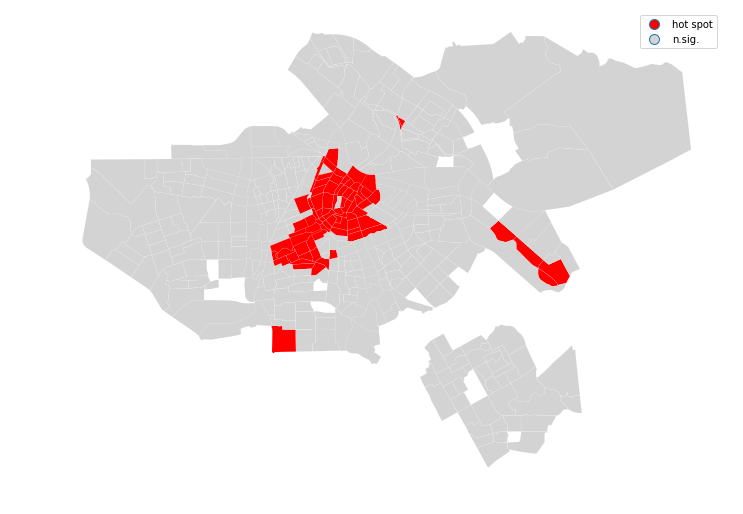

In [160]:
buurt = buurt
from matplotlib import colors
hmap = colors.ListedColormap(['red', 'lightgrey'])
fig, ax = plt.subplots(figsize=(12, 12))
buurt.assign(cl=labels).plot(column='cl', categorical=True, \
             k=2, cmap=hmap, linewidth=0.1, ax=ax, \
             edgecolor='white', legend=True)
ax.set_axis_off()

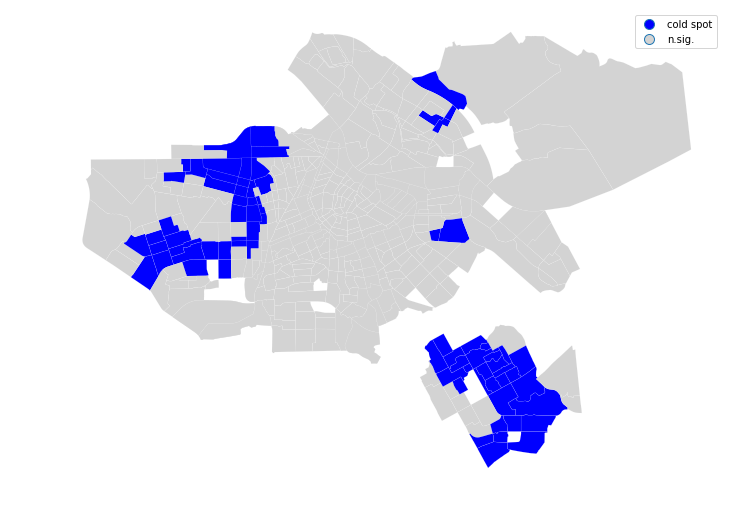

In [162]:
## doughnut = quandrant 2 (below average rents srrounded by high-rent neigbours)
spots = ['n.sig.', 'cold spot']
labels = [spots[i] for i in coldspot*1]

buurt = buurt
hmap = colors.ListedColormap(['blue', 'lightgrey'])
fig, ax = plt.subplots(figsize=(12, 12))
buurt.assign(cl=labels).plot(column='cl', categorical=True, \
             k=2, cmap=hmap, linewidth=0.1, ax=ax, \
             edgecolor='white', legend=True)
ax.set_axis_off()

In [168]:
sig = 1 * (li.p_sim < 0.05)
hotspot = 1 * (sig * li.q==1)
coldspot = 3 * (sig * li.q==3)
doughnut = 2 * (sig * li.q==2)
diamond = 4 * (sig * li.q==4) 
spots = hotspot + coldspot + doughnut + diamond
#spots

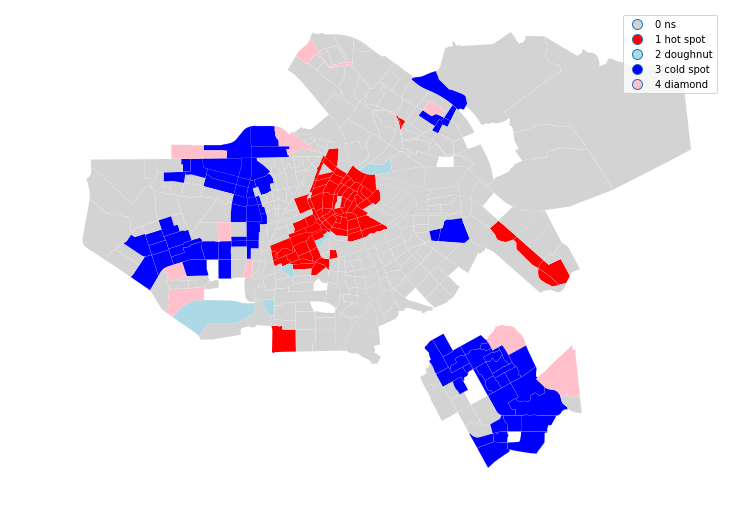

In [166]:
spot_labels = [ '0 ns', '1 hot spot', '2 doughnut', '3 cold spot', '4 diamond']
labels = [spot_labels[i] for i in spots]

hmap = colors.ListedColormap([ 'lightgrey', 'red', 'lightblue', 'blue', 'pink'])
fig, ax = plt.subplots(1, figsize=(12, 12))
buurt.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()

- Quadrant 1 --> High prices in focal neighboorhood, surrounded by nb's with high prices (hotspot)
- Quadrant 2 --> Low prices in focal neighboorhood, surrounded by nb's with high prices (doughnut)
- Quadrant 3 --> Low prices in focal neighboorhood, surrounded by low prices (coldspot)
- Quadrant 4 --> High values in focal neighboorhood, surrounded by nb's with low values (Diamonds)

can be used - imagine having a Timeseries of these maps/ fusion processses studying spread patterns. (gentrification processes)/ inward diffusion processes. (from the suburbs to the center districts).